In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

In [2]:
data = pd.read_csv("orig_train.csv")

In [3]:
data.head()

,PRODUCT,AGE,AREA,RESIDENTIAL_PLACE,EDUCATION,MARITAL_STATUS,HOUSEHOLD_MEMBERS,NO_OF_DEPENDENTS,INCOME,WORK_SENIORITY,...,LENGTH_RELATIONSHIP_WITH_CLIENT,DEBIT_CARD,CURRENT_ACCOUNT,SAVING_ACCOUNT,SALARY_ACCOUNT,FOREIGN_ACCOUNT,FINALIZED_LOAN,DEPOSIT,PENSION_FUNDS,DEFAULT_FLAG
0,C,65,County capital,Owner without mortgage,University,married,2,0,1245.0,5,...,1,0,0,0,0,0,0,0,0,0
1,C,64,County capital,Owner without mortgage,University,married,2,0,1380.0,5,...,8,0,0,0,0,0,0,0,0,0
2,F,30,Urban area,Living with family,University,married,2,0,1131.0,2,...,1,1,1,0,0,0,0,0,0,0
3,C,39,County capital,Owner without mortgage,Post-graduate,divorced,1,0,1730.0,9,...,2,0,0,0,0,0,0,0,0,0
4,B,38,County capital,Owner without mortgage,Highschool,single,1,0,1189.0,5,...,1,1,1,0,0,0,0,0,0,0


# Descriptions of Continuous Variables

   * age - the age of the person in years
   * household_members - the number of people in the household of the client
   * no_of_dependents - the number of people financially dependent on this particular person
   * income - monthly income
   * work_seniority - tenure/ professional experience in a given industry
   * business age - the number of years that a company has been legally in operation
   * length_relationship_with_client - duration of the relationship with the client
   * debit_card - possession of a debit card (1 - true, 0 - false)
   * current_account - client's possession of a current account (1 - true, 0 - false)
   * saving_account - client's possession of a savings account (1 - true, 0 - false)
   * salary_account - client's possession of an account designated for receiving salaries (1 - true, 0 - false)
   * foreign_account - client's possession of a foreign/currency account (1 - true, 0 - false)
   * finalized_loan - whether a current loan has been granted (1 - yes, 0 - no)
   * deposit - whether a deposit payment was made when signing the contract (1 - yes, 0, - no)
   * pension_funds - pension funds, column only with values 0, so to be removed
   * default_flag - whether the client has debts (1 - yes, 0 - no)

# Descriptions of Textual Variables

   * product - type of loan/service chosen by a client
   * area - type of the client's area of residence
   * residential_place - the client's residential status: owner without mortgage - owner of a house without a mortgage, owner          with mortgage, renter, living with family, other - other
   * education - the highest level of education obtained
   * marital status - single, widow, married, divorced
   * economic sector - sector of economic activity
   * employee_no - number of employees in the company that the client is currently working



### Business goal

We are going to prepare a model for the bank to help predict whether a given customer should receive a particular product (A-F). We plan to predict a value in the Finalised Loan column that takes 0 when the customer doesn't receive a loan and 1 when they receive one.

In [4]:
# Let's see the types of features we're working with

def classify_columns(df):

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    binary_cols = [col for col in numeric_cols if df[col].dropna().isin([0, 1]).all()]

    numeric_cols = [col for col in numeric_cols if col not in binary_cols]

    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    return numeric_cols, binary_cols, categorical_cols

numeric_columns, binary_columns, categorical_columns = classify_columns(data)

{

    "Numeric Columns": numeric_columns,

    "Binary Columns": binary_columns,

    "Categorical Columns": categorical_columns

}

{'Numeric Columns': ['AGE',
  'HOUSEHOLD_MEMBERS',
  'NO_OF_DEPENDENTS',
  'INCOME',
  'WORK_SENIORITY',
  'BUSINESS AGE',
  'LENGTH_RELATIONSHIP_WITH_CLIENT'],
 'Binary Columns': ['DEBIT_CARD',
  'CURRENT_ACCOUNT',
  'SAVING_ACCOUNT',
  'SALARY_ACCOUNT',
  'FOREIGN_ACCOUNT',
  'FINALIZED_LOAN',
  'DEPOSIT',
  'PENSION_FUNDS',
  'DEFAULT_FLAG'],
 'Categorical Columns': ['PRODUCT',
  'AREA',
  'RESIDENTIAL_PLACE',
  'EDUCATION',
  'MARITAL_STATUS',
  'ECONOMIC_SECTOR',
  'EMPLOYEE_NO']}

In [5]:
# Summary statistics for numerical features
numerical_summary = data.describe()

numerical_summary

,AGE,HOUSEHOLD_MEMBERS,NO_OF_DEPENDENTS,INCOME,WORK_SENIORITY,BUSINESS AGE,LENGTH_RELATIONSHIP_WITH_CLIENT,DEBIT_CARD,CURRENT_ACCOUNT,SAVING_ACCOUNT,SALARY_ACCOUNT,FOREIGN_ACCOUNT,FINALIZED_LOAN,DEPOSIT,PENSION_FUNDS,DEFAULT_FLAG
count,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.0,15097.000000
mean,43.584553,1.717229,0.199510,1958.071916,6.647347,17.938001,4.996556,0.384116,0.485461,0.000397,0.123203,0.000132,0.164205,0.003709,0.0,0.057230
std,13.460964,0.759843,0.493135,1772.153274,5.647763,12.477914,4.900952,0.486402,0.499805,0.019932,0.328681,0.011509,0.370474,0.060793,0.0,0.232289
min,19.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,32.000000,1.000000,0.000000,1007.420000,3.000000,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,42.000000,2.000000,0.000000,1426.495000,5.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,56.000000,2.000000,0.000000,2290.000000,8.000000,21.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,74.000000,5.000000,4.000000,40621.600000,46.000000,116.000000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


* We have 15097 observations in the set. 
* There are only values '0' in the Pension Funds column - this column is suitable for deletion. It does not contribute any information to the model.
* Maximum value of column 'Business Age' equals 116 and maximum value of column 'Length relationship with client' equals 110 which means these features don't relate to the clients but the company they're working in

In [6]:
# Frequency counts for categorical features
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_summary = data[categorical_columns].describe()

categorical_summary

,PRODUCT,AREA,RESIDENTIAL_PLACE,EDUCATION,MARITAL_STATUS,ECONOMIC_SECTOR,EMPLOYEE_NO
count,15097,15097,15097,15097,15097,15097,15097
unique,6,4,5,10,4,18,9
top,C,County capital,Owner without mortgage,University,married,Missing,Missing
freq,6779,7586,8457,5457,8141,4009,3338


* There are no categorical variables where we would have a very large number of categories (for all columns there are less than 20 values). 
* In two columns, the most common value is Missing. We will probably try to imputate them using Advanced Imputation Techniques (Random Forest Model).
* There are two ordered categorical variables: 'Education' and 'Employee No' and 5 nominal variables.

In [7]:
data["AREA"].unique()

array(['County capital', 'Urban area', 'Rural area', 'Missing'],
      dtype=object)

* We have some missing values

In [8]:
data["PRODUCT"].unique()

array(['C', 'F', 'B', 'E', 'D', 'A'], dtype=object)

In [9]:
data["RESIDENTIAL_PLACE"].unique()

array(['Owner without mortgage', 'Living with family',
       'Owner with mortgage', 'Rental', 'Other'], dtype=object)

In [10]:
data["EDUCATION"].unique()

array(['University', 'Post-graduate', 'Highschool', 'Missing',
       'Post secondary school', 'Other', 'College', 'Vocational school',
       'Middle school', 'Primary school'], dtype=object)

* Again some Missing values

In [11]:
data["MARITAL_STATUS"].unique()

array(['married', 'divorced', 'single', 'widow'], dtype=object)

In [12]:
data["ECONOMIC_SECTOR"].unique()

array(['Missing', 'Other', 'Education', 'Manufacturing',
       'Public administration and defence', 'Wholesale and retail trade',
       'Human health and social work activities',
       'Professional, scientific and technical activities',
       'Electricity and gas', 'Transportation and storage',
       'Construction', 'Water supply', 'Mining and quarrying',
       'Information and communication',
       'Agriculture, hunting and forestry',
       'Financial and insurance activities',
       'Accommodation and food service activities',
       'Real estate activities'], dtype=object)

In [13]:
data["EMPLOYEE_NO"].unique()

array(['Missing', '> 1.000', 'between 11-20', 'between 101-250',
       'between 0-10', 'between 51-100', 'between 21-50',
       'between 501-1.000', 'between 251-500'], dtype=object)

In [14]:
# Binary columns 

binary_columns = [col for col in data.columns if data[col].dropna().isin([0, 1]).all() ]

# Summary table for binary columns

binary_summary = data[binary_columns].apply(pd.Series.value_counts).T

binary_summary

,0,1
DEBIT_CARD,9298.0,5799.0
CURRENT_ACCOUNT,7768.0,7329.0
SAVING_ACCOUNT,15091.0,6.0
SALARY_ACCOUNT,13237.0,1860.0
FOREIGN_ACCOUNT,15095.0,2.0
FINALIZED_LOAN,12618.0,2479.0
DEPOSIT,15041.0,56.0
PENSION_FUNDS,15097.0,NaN
DEFAULT_FLAG,14233.0,864.0


 Distribution of FINALIZED_LOAN: About 83.58% of the clients in the dataset have FINALISED_LOAN = 0, 
 while approximately 16.42% have FINALISED_LOAN = 1. This unbalanced distribution indicates that we will need to
 apply class-balancing techniques or adjust model evaluation metrics accordingly to avoid biases 
 in favour of the dominant class. From this data, we see that negative credit decisions are given more often than the positive ones

Distribution of SAVING_ACCOUNT, FOREIGN_ACCOUNT and DEPOSIT is very skewed and we 
might want to remove these rows in the future

In [15]:
# Checking for missing values
missing_values = data.isnull().sum()

missing_values

PRODUCT                            0
AGE                                0
AREA                               0
RESIDENTIAL_PLACE                  0
EDUCATION                          0
MARITAL_STATUS                     0
HOUSEHOLD_MEMBERS                  0
NO_OF_DEPENDENTS                   0
INCOME                             0
WORK_SENIORITY                     0
BUSINESS AGE                       0
ECONOMIC_SECTOR                    0
EMPLOYEE_NO                        0
LENGTH_RELATIONSHIP_WITH_CLIENT    0
DEBIT_CARD                         0
CURRENT_ACCOUNT                    0
SAVING_ACCOUNT                     0
SALARY_ACCOUNT                     0
FOREIGN_ACCOUNT                    0
FINALIZED_LOAN                     0
DEPOSIT                            0
PENSION_FUNDS                      0
DEFAULT_FLAG                       0
dtype: int64

There are only zeros here because all the missing values in this csv are marked as "Missing"

In [16]:
# Proportion of missing values
missing_proportions = {}
for column in categorical_columns:
    total = len(data[column])
    missing_count = sum(data[column] == 'Missing')
    missing_proportions[column] = (missing_count / total) * 100

missing_proportions_df = pd.DataFrame(missing_proportions.items(), columns=['Column', 'Missing Proportion (%)'])

missing_proportions_df

,Column,Missing Proportion (%)
0,PRODUCT,0.000000
1,AREA,0.218586
2,RESIDENTIAL_PLACE,0.000000
3,EDUCATION,4.577068
4,MARITAL_STATUS,0.000000
5,ECONOMIC_SECTOR,26.554945
6,EMPLOYEE_NO,22.110353


* As the number of missing data in the columns EMPLOYEE_NO and ECONOMIC_SECTOR exceeds 20 % we might want to imputate the missing values. We will also try to imputate missing values in column Education.

* We are going to remove rows with missing value in column Area

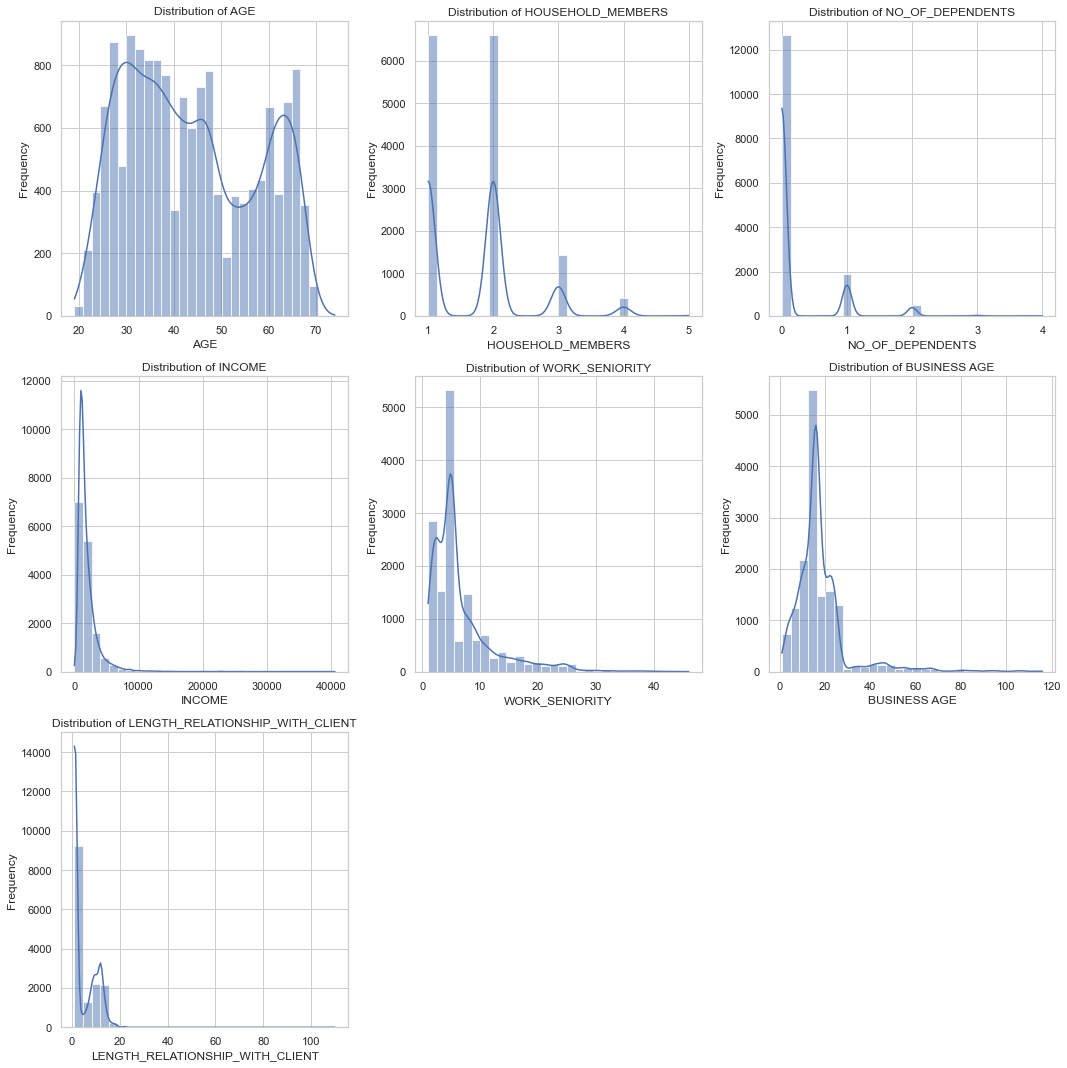

In [17]:
sns.set(style="whitegrid")

# Subset of numerical columns for visualization
numerical_columns = ['AGE', 'HOUSEHOLD_MEMBERS', 'NO_OF_DEPENDENTS','INCOME', 'WORK_SENIORITY', 'BUSINESS AGE', 'LENGTH_RELATIONSHIP_WITH_CLIENT']

# Plotting histograms for the selected numerical features
plt.figure(figsize=(15, 15))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

* It's interesting that people who are in their 50s are less likely to take a loan than people in their 60s
* There are many people with INCOME close to 0. We are curious whether that indicate "No data" or actually a really small income. We'll check that later.

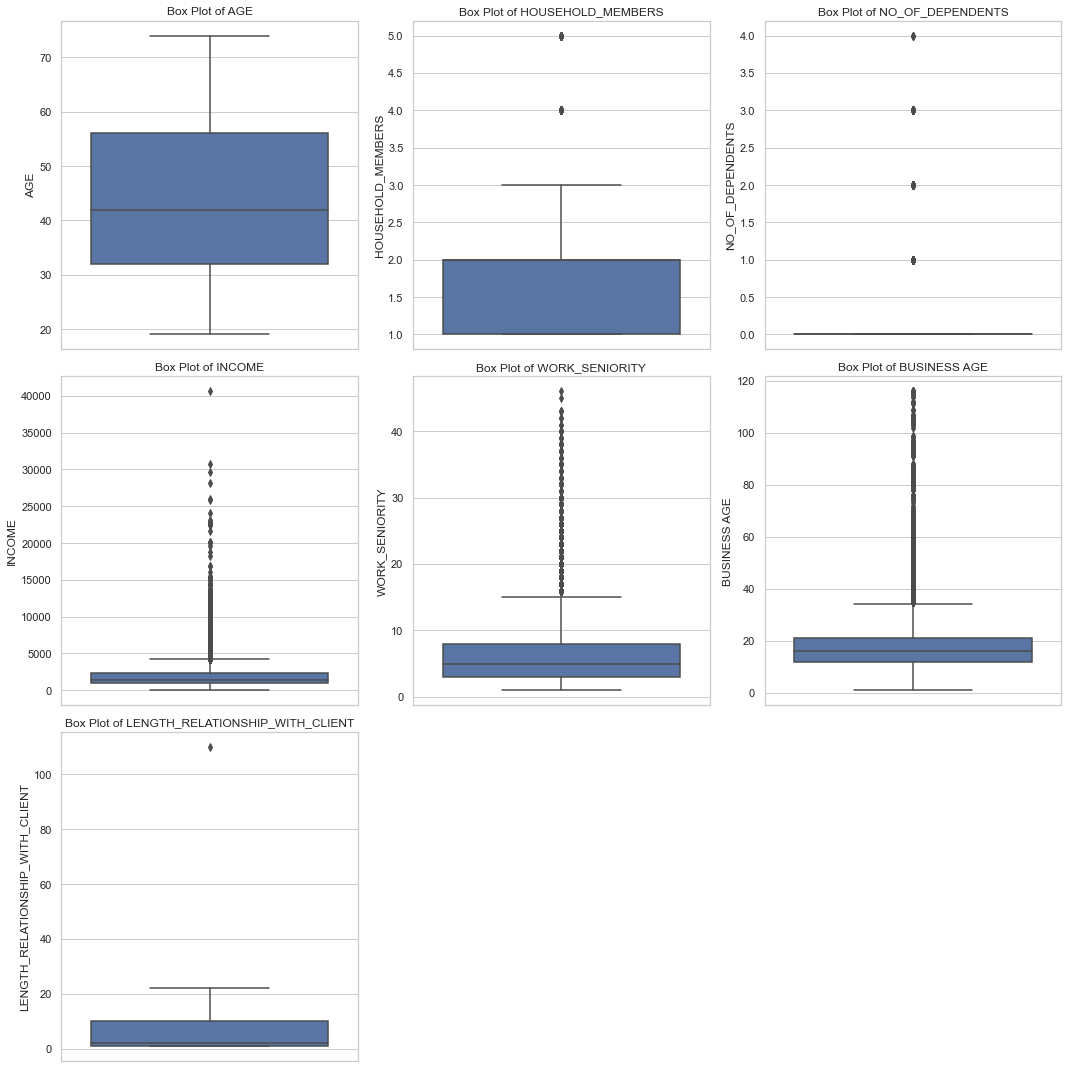

In [18]:
# Plotting box plots for the selected numerical features

plt.figure(figsize=(15, 15))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()

* We can see that with a high probability the value that exceeds 100 in column Length Relationship With Client is probably a mistake beacuse it's far from other observations on the boxplot. So now this column can actually mean something different than we thought, for example the length of relationship between bank and the client
* Most people who want to take a loan have no dependents. That's why any value different than 0 is treated on this boxplot as an outlier.

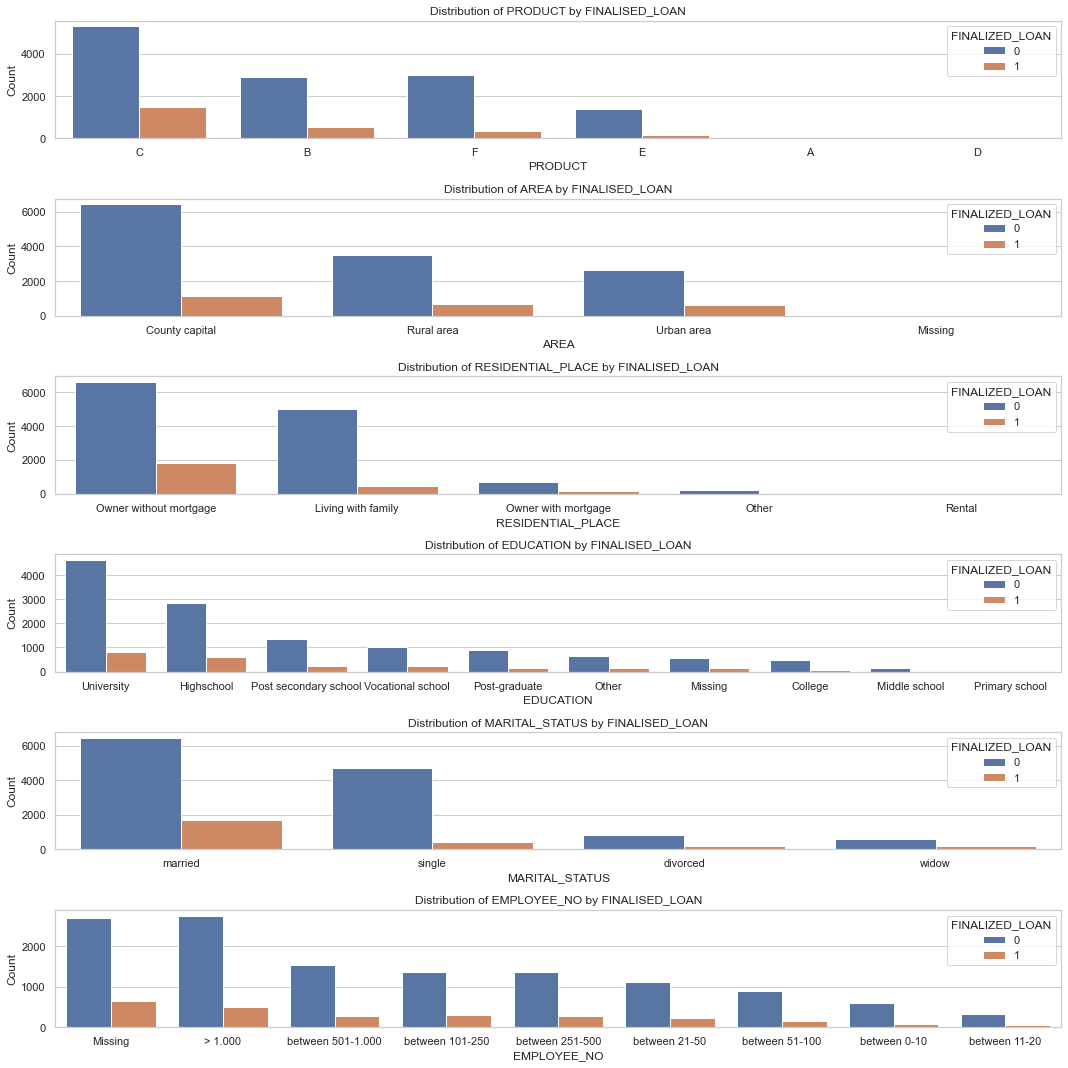

In [19]:
# Plotting bar plots for the selected categorical features against the FINALISED_LOAN

categorical_columns = ['PRODUCT', 'AREA', 'RESIDENTIAL_PLACE', 'EDUCATION', 'MARITAL_STATUS', 'EMPLOYEE_NO']
plt.figure(figsize=(15, 15))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(6, 1, i)
    order = data[column].value_counts().index
    sns.countplot(x=column, hue='FINALIZED_LOAN', data=data, order = order)
    plt.title(f'Distribution of {column} by FINALISED_LOAN')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='FINALIZED_LOAN', loc='upper right')

plt.tight_layout()
plt.show()

Insights:
* Products A and D are very rare. The most common one is product C.
* Product B seems to be easier to get. Although more people try to take this loan, there are less negative decisions than in case of product F
* Most of the clients come from County capital.
* Most of the clients are owners without mortgage. They're University graduate and they're married.
* Most of the companies that the clients are working in have more than 1000 employees.

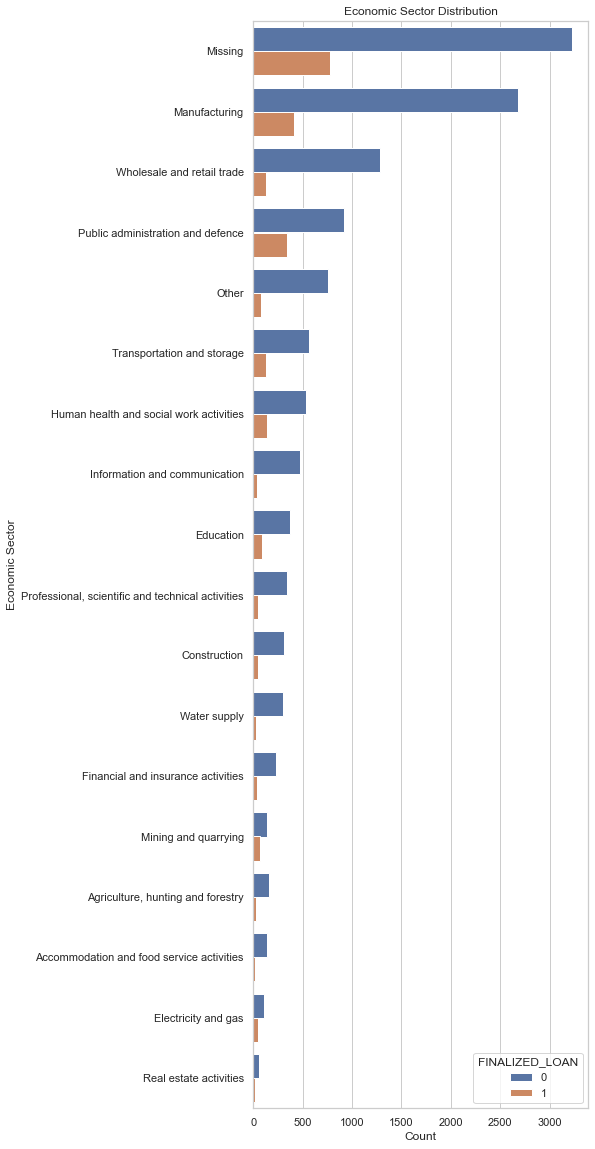

In [20]:
# I have changed the orientation of the plot so that the values on the axis can be readable
plt.figure(figsize=(6, 20)) 
order = data['ECONOMIC_SECTOR'].value_counts().index
sns.countplot(y='ECONOMIC_SECTOR', hue = 'FINALIZED_LOAN', data=data, order = order) 
plt.title('Economic Sector Distribution')
plt.xlabel('Count')
plt.ylabel('Economic Sector') 
plt.show()

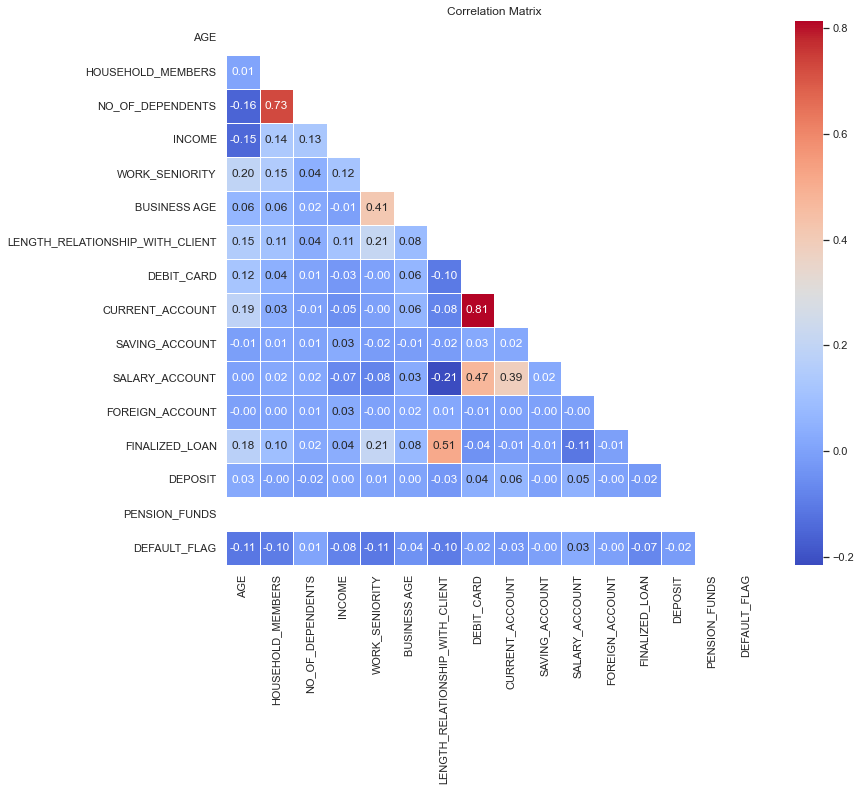

In [21]:
# Pearson Correlation matrix
corr = data.corr(method = 'pearson')

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))

# Heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

* We can see that there is a high correlation between column Current_Account and column Debit_Card, so we'll remove one of them.
* The same situation is with columns Number of dependents and Household members.
* We can notice that column Finalised Loan that we are going to predict is quite strongly correlated with column Length relationoship with Client so that feature might be crucial in our model

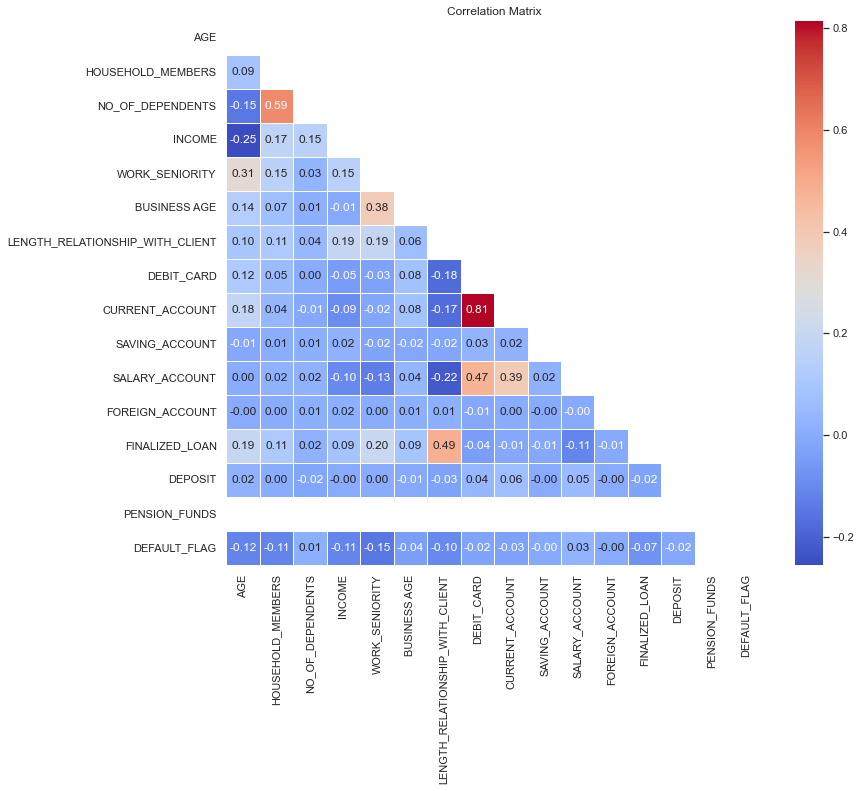

In [22]:
# Spearman Correlation matrix 
corr = data.corr(method = 'spearman')

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))

# Heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<Figure size 800x640 with 0 Axes>

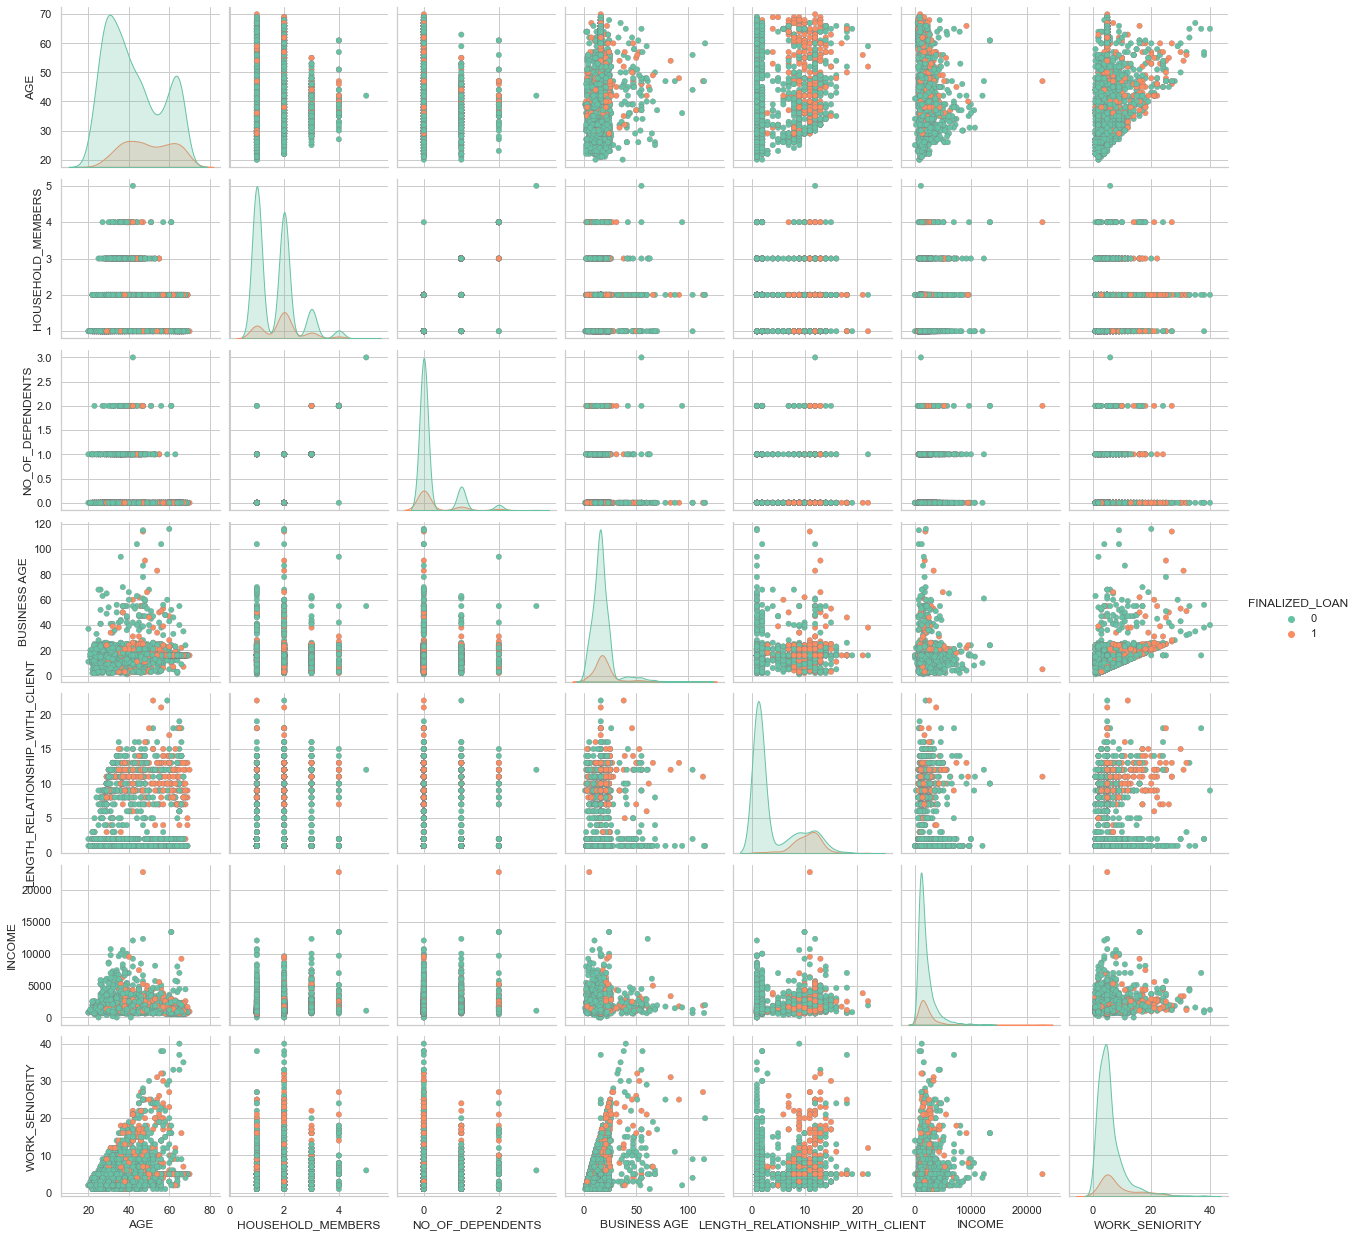

In [23]:
selected_columns = [
    "AGE",
    "HOUSEHOLD_MEMBERS",
    "NO_OF_DEPENDENTS",
    "BUSINESS AGE",
    "LENGTH_RELATIONSHIP_WITH_CLIENT",
    "FINALIZED_LOAN",
    "INCOME",
    "WORK_SENIORITY"
]
subset_data = data[selected_columns].sample(frac=0.1, random_state=1)


plt.figure(figsize=(10, 8), dpi=80)
sns.pairplot(
    subset_data,
    kind="scatter",
    hue="FINALIZED_LOAN",
    plot_kws=dict(s=30, edgecolor="gray", linewidth=0.3),
    palette="Set2",
)
plt.show()

* There aren't any groups of variables that can be easily separated from each other

In [24]:
data.groupby(["PRODUCT","FINALIZED_LOAN"]).agg("size").reset_index(name="count")

,PRODUCT,FINALIZED_LOAN,count
0,A,0,31
1,A,1,11
2,B,0,2891
3,B,1,516
4,C,0,5316
5,C,1,1463
6,D,0,9
7,D,1,4
8,E,0,1370
9,E,1,152


In [25]:
data.groupby(["AREA","FINALIZED_LOAN"]).size().reset_index()

,AREA,FINALIZED_LOAN,0
0,County capital,0,6429
1,County capital,1,1157
2,Missing,0,32
3,Missing,1,1
4,Rural area,0,3525
5,Rural area,1,667
6,Urban area,0,2632
7,Urban area,1,654


In [26]:
data.groupby(["RESIDENTIAL_PLACE","FINALIZED_LOAN"]).size().reset_index()

,RESIDENTIAL_PLACE,FINALIZED_LOAN,0
0,Living with family,0,5041
1,Living with family,1,464
2,Other,0,232
3,Other,1,14
4,Owner with mortgage,0,702
5,Owner with mortgage,1,159
6,Owner without mortgage,0,6617
7,Owner without mortgage,1,1840
8,Rental,0,26
9,Rental,1,2


In [27]:
data.groupby(["EDUCATION","FINALIZED_LOAN"]).size().reset_index()

,EDUCATION,FINALIZED_LOAN,0
0,College,0,486
1,College,1,76
2,Highschool,0,2837
3,Highschool,1,614
4,Middle school,0,160
5,Middle school,1,35
6,Missing,0,550
7,Missing,1,141
8,Other,0,658
9,Other,1,161


In [28]:
data.groupby(["MARITAL_STATUS","FINALIZED_LOAN"]).size().reset_index()

,MARITAL_STATUS,FINALIZED_LOAN,0
0,divorced,0,860
1,divorced,1,185
2,married,0,6450
3,married,1,1691
4,single,0,4681
5,single,1,432
6,widow,0,627
7,widow,1,171


In [29]:
data.groupby(["HOUSEHOLD_MEMBERS","FINALIZED_LOAN"]).size().reset_index()

,HOUSEHOLD_MEMBERS,FINALIZED_LOAN,0
0,1,0,5858
1,1,1,754
2,2,0,5248
3,2,1,1360
4,3,0,1167
5,3,1,262
6,4,0,329
7,4,1,101
8,5,0,16
9,5,1,2


In [30]:
data.groupby(["NO_OF_DEPENDENTS","FINALIZED_LOAN"]).size().reset_index()

,NO_OF_DEPENDENTS,FINALIZED_LOAN,0
0,0,0,10624
1,0,1,2047
2,1,0,1559
3,1,1,321
4,2,0,405
5,2,1,105
6,3,0,27
7,3,1,5
8,4,0,3
9,4,1,1


In [31]:
data.groupby(["INCOME","FINALIZED_LOAN"]).size().reset_index()

,INCOME,FINALIZED_LOAN,0
0,0.00,0,41
1,143.33,0,1
2,174.66,0,1
3,187.00,0,1
4,196.33,0,1
...,...,...,...
8822,26028.75,0,1
8823,28147.56,0,1
8824,29725.00,0,1
8825,30746.00,0,1


In [32]:
data.groupby(["WORK_SENIORITY","FINALIZED_LOAN"]).size().reset_index()

,WORK_SENIORITY,FINALIZED_LOAN,0
0,1,0,584
1,1,1,39
2,2,0,2084
3,2,1,147
4,3,0,1361
...,...,...,...
80,42,0,2
81,43,0,2
82,43,1,1
83,45,0,1


In [33]:
data.groupby(["BUSINESS AGE","FINALIZED_LOAN"]).size().reset_index().tail(10)     

,BUSINESS AGE,FINALIZED_LOAN,0
186,107,1,3
187,109,0,2
188,109,1,1
189,111,0,1
190,112,0,3
191,112,1,1
192,114,1,2
193,115,0,3
194,116,0,4
195,116,1,2


In [34]:
data.groupby(["ECONOMIC_SECTOR","FINALIZED_LOAN"]).size().reset_index()

,ECONOMIC_SECTOR,FINALIZED_LOAN,0
0,Accommodation and food service activities,0,142
1,Accommodation and food service activities,1,17
2,"Agriculture, hunting and forestry",0,165
3,"Agriculture, hunting and forestry",1,31
4,Construction,0,312
5,Construction,1,46
6,Education,0,368
7,Education,1,92
8,Electricity and gas,0,106
9,Electricity and gas,1,46


In [35]:
data.groupby(["EMPLOYEE_NO","FINALIZED_LOAN"]).size().reset_index()

,EMPLOYEE_NO,FINALIZED_LOAN,0
0,> 1.000,0,2754
1,> 1.000,1,490
2,Missing,0,2691
3,Missing,1,647
4,between 0-10,0,592
5,between 0-10,1,92
6,between 101-250,0,1353
7,between 101-250,1,291
8,between 11-20,0,328
9,between 11-20,1,46


In [36]:
data.groupby(["LENGTH_RELATIONSHIP_WITH_CLIENT","FINALIZED_LOAN"]).size().reset_index()

,LENGTH_RELATIONSHIP_WITH_CLIENT,FINALIZED_LOAN,0
0,1,0,5901
1,1,1,34
2,2,0,2962
3,2,1,15
4,3,0,109
5,3,1,28
6,4,0,155
7,4,1,26
8,5,0,147
9,5,1,19


In [37]:
# Low variance columns: These columns are highly skewed with a dominant value, reducing their potential predictive power.
columns_to_remove_low_variance = ['SAVING_ACCOUNT', 'FOREIGN_ACCOUNT', 'DEPOSIT', 'PENSION_FUNDS']

# Columns to remove due to concerns of high correlation or redundancy
columns_to_remove_correlation_concerns = ['HOUSEHOLD_MEMBERS', 'DEBIT_CARD']

# All columns to remove
columns_to_remove = columns_to_remove_low_variance + columns_to_remove_correlation_concerns

# Removing the columns from the dataset
data_cleaned = data.drop(columns=columns_to_remove)


data_cleaned.head()

,PRODUCT,AGE,AREA,RESIDENTIAL_PLACE,EDUCATION,MARITAL_STATUS,NO_OF_DEPENDENTS,INCOME,WORK_SENIORITY,BUSINESS AGE,ECONOMIC_SECTOR,EMPLOYEE_NO,LENGTH_RELATIONSHIP_WITH_CLIENT,CURRENT_ACCOUNT,SALARY_ACCOUNT,FINALIZED_LOAN,DEFAULT_FLAG
0,C,65,County capital,Owner without mortgage,University,married,0,1245.0,5,16,Missing,Missing,1,0,0,0,0
1,C,64,County capital,Owner without mortgage,University,married,0,1380.0,5,16,Missing,Missing,8,0,0,0,0
2,F,30,Urban area,Living with family,University,married,0,1131.0,2,6,Other,> 1.000,1,1,0,0,0
3,C,39,County capital,Owner without mortgage,Post-graduate,divorced,0,1730.0,9,13,Education,between 11-20,2,0,0,0,0
4,B,38,County capital,Owner without mortgage,Highschool,single,0,1189.0,5,16,Missing,Missing,1,1,0,0,0


In [38]:
# Let's check the rows, which are duplicated. We will not remove them, because they may have some value to our model
data_cleaned[data_cleaned.duplicated()].shape[0]


65

In [39]:
# We have removed rows with 'Missing' values in 'AREA'

data_no_missing_area = data_cleaned[data_cleaned['AREA'] != 'Missing']

rows_after_removal = data_no_missing_area.shape[0]
rows_removed = data_cleaned.shape[0] - rows_after_removal

data = data_no_missing_area

rows_removed, rows_after_removal

(33, 15064)

In [40]:
# Let's now focus on outliers. We will focus on lower percentile 1% and upper percentile 99% and change all these values
data_no_missing_area_copy = data_no_missing_area.copy()
for col in ['AGE', 'WORK_SENIORITY', 'BUSINESS AGE']:
    lower_bound = data_no_missing_area_copy[col].quantile(0.01)
    upper_bound = data_no_missing_area_copy[col].quantile(0.99)
    data_no_missing_area_copy[col] = data_no_missing_area_copy[col].clip(lower=lower_bound, upper=upper_bound)

In [41]:
# Let's change outliers for Income
income_upper_bound = data_no_missing_area_copy['INCOME'].quantile(0.99)
income_median = data_no_missing_area_copy['INCOME'].median()
data_no_missing_area_copy['INCOME'] = np.where(data_no_missing_area_copy['INCOME'] > income_upper_bound, income_median, data_no_missing_area_copy['INCOME'])

In [42]:
# Deleting extraordinary outliers. Firstly let's consider length_relationship_with_client

data_no_outlier_relationship=data_no_missing_area_copy[data_no_missing_area['LENGTH_RELATIONSHIP_WITH_CLIENT']<100]
rows_after_removal=data_no_outlier_relationship.shape[0]
rows_removed = data_no_missing_area_copy.shape[0] - rows_after_removal

rows_removed, rows_after_removal

(1, 15063)

In [43]:
# Now let's take the first column with types of products. We can clearly see that the products A and D have infinitesimal number of appearences
data_no_outlier_products=data_no_outlier_relationship[(data_no_outlier_relationship['PRODUCT']!='A') & (data_no_outlier_relationship['PRODUCT']!='D')]
rows_after_removal=data_no_outlier_products.shape[0]
rows_removed=data_no_outlier_relationship.shape[0]-rows_after_removal

rows_removed, rows_after_removal

(54, 15009)

In [44]:
data = data_no_outlier_products.copy()

In [45]:
economic_sector_imputation = data

education_categories = [['Primary school', 'Middle school', 'Highschool', 'Vocational school', 'Post secondary school', 'College', 'University', 'Post-graduate', 'Other', 'Missing']]

encoder_education = OrdinalEncoder(categories=education_categories)

# Fit and transform the 'education' data
encoded_education = encoder_education.fit_transform(economic_sector_imputation[["EDUCATION"]])

economic_sector_imputation['EDUCATION_ENCODED']=encoded_education

#Now encoding Employee_No column

employee_no_categories=[['between 0-10','between 11-20','between 21-50','between 51-100','between 101-250','between 251-500','between 501-1.000','> 1.000','Missing']]

encoder_employee = OrdinalEncoder(categories=employee_no_categories)

# Fit and transform the 'education' data
encoded_employee = encoder_employee.fit_transform(economic_sector_imputation[["EMPLOYEE_NO"]])

economic_sector_imputation['EMPLOYEE_NO_ENCODED']=encoded_employee

one_hot_columns=economic_sector_imputation.select_dtypes(include=['object']).columns.drop(['EDUCATION','EMPLOYEE_NO',"ECONOMIC_SECTOR"]).tolist()

economic_sector_imputation=pd.get_dummies(economic_sector_imputation,columns=one_hot_columns)

economic_sector_imputation =economic_sector_imputation.drop(columns=['EDUCATION', 'EMPLOYEE_NO'])

economic_known=economic_sector_imputation[economic_sector_imputation["ECONOMIC_SECTOR"]!="Missing"]
economic_unknown=economic_sector_imputation[economic_sector_imputation["ECONOMIC_SECTOR"]=="Missing"]

# Assuming all other columns are used as features and have been appropriately encoded
features = economic_known.drop(['ECONOMIC_SECTOR'], axis=1)
target = economic_known['ECONOMIC_SECTOR']

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(features, target)

predictions = model.predict(economic_unknown.drop(['ECONOMIC_SECTOR'], axis=1))

data.loc[data['ECONOMIC_SECTOR']=="Missing","ECONOMIC_SECTOR"]=predictions

data["ECONOMIC_SECTOR"].unique()

array(['Manufacturing', 'Other', 'Education',
       'Wholesale and retail trade', 'Public administration and defence',
       'Human health and social work activities',
       'Professional, scientific and technical activities',
       'Electricity and gas', 'Transportation and storage',
       'Construction', 'Water supply', 'Mining and quarrying',
       'Information and communication',
       'Agriculture, hunting and forestry',
       'Financial and insurance activities',
       'Accommodation and food service activities',
       'Real estate activities'], dtype=object)

In [46]:
employee_no_imputation = data

education_categories = [['Primary school', 'Middle school', 'Highschool', 'Vocational school', 'Post secondary school', 'College', 'University', 'Post-graduate', 'Other', 'Missing']]

encoder_education = OrdinalEncoder(categories=education_categories)

# Fit and transform the 'education' data
encoded_education = encoder_education.fit_transform(employee_no_imputation[["EDUCATION"]])

employee_no_imputation['EDUCATION_ENCODED']=encoded_education

one_hot_columns=employee_no_imputation.select_dtypes(include=['object']).columns.drop(['EDUCATION','EMPLOYEE_NO']).tolist()

employee_no_imputation=pd.get_dummies(employee_no_imputation,columns=one_hot_columns)

employee_no_imputation =employee_no_imputation.drop(columns=['EDUCATION'])

employee_no_known=employee_no_imputation[employee_no_imputation["EMPLOYEE_NO"]!="Missing"]
employee_no_unknown=employee_no_imputation[employee_no_imputation["EMPLOYEE_NO"]=="Missing"]

# Assuming all other columns are used as features and have been appropriately encoded
features = employee_no_known.drop(['EMPLOYEE_NO'], axis=1)
target = employee_no_known['EMPLOYEE_NO']

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(features, target)

predictions = model.predict(employee_no_unknown.drop(['EMPLOYEE_NO'], axis=1))

data.loc[data['EMPLOYEE_NO']=="Missing","EMPLOYEE_NO"]=predictions

data["EMPLOYEE_NO"].unique()

array(['> 1.000', 'between 11-20', 'between 101-250', 'between 0-10',
       'between 51-100', 'between 21-50', 'between 501-1.000',
       'between 251-500'], dtype=object)

In [47]:
education_imputation = data

#Now encoding Employee_No column

employee_no_categories=[['between 0-10','between 11-20','between 21-50','between 51-100','between 101-250','between 251-500','between 501-1.000','> 1.000','Missing']]

encoder_employee = OrdinalEncoder(categories=employee_no_categories)

# Fit and transform the 'education' data
encoded_employee = encoder_employee.fit_transform(education_imputation[["EMPLOYEE_NO"]])

education_imputation['EMPLOYEE_NO_ENCODED']=encoded_employee

one_hot_columns=education_imputation.select_dtypes(include=['object']).columns.drop(['EDUCATION','EMPLOYEE_NO']).tolist()

education_imputation=pd.get_dummies(education_imputation,columns=one_hot_columns)

education_imputation =education_imputation.drop(columns=['EMPLOYEE_NO'])

education_known=education_imputation[education_imputation["EDUCATION"]!="Missing"]
education_unknown=education_imputation[education_imputation["EDUCATION"]=="Missing"]

# Assuming all other columns are used as features and have been appropriately encoded
features = education_known.drop(['EDUCATION'], axis=1)
target = education_known['EDUCATION']

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(features, target)

predictions = model.predict(education_unknown.drop(['EDUCATION'], axis=1))

data.loc[data['EDUCATION']=="Missing","EDUCATION"]=predictions

data["EDUCATION"].unique()

array(['University', 'Post-graduate', 'Highschool', 'Other',
       'Post secondary school', 'College', 'Vocational school',
       'Middle school', 'Primary school'], dtype=object)

In [48]:
# Proportion of missing values
missing_proportions = {}
for column in categorical_columns:
    total = len(data[column])
    missing_count = sum(data[column] == 'Missing')
    missing_proportions[column] = (missing_count / total) * 100

missing_proportions_df = pd.DataFrame(missing_proportions.items(), columns=['Column', 'Missing Proportion (%)'])

missing_proportions_df

,Column,Missing Proportion (%)
0,PRODUCT,0.0
1,AREA,0.0
2,RESIDENTIAL_PLACE,0.0
3,EDUCATION,0.0
4,MARITAL_STATUS,0.0
5,EMPLOYEE_NO,0.0


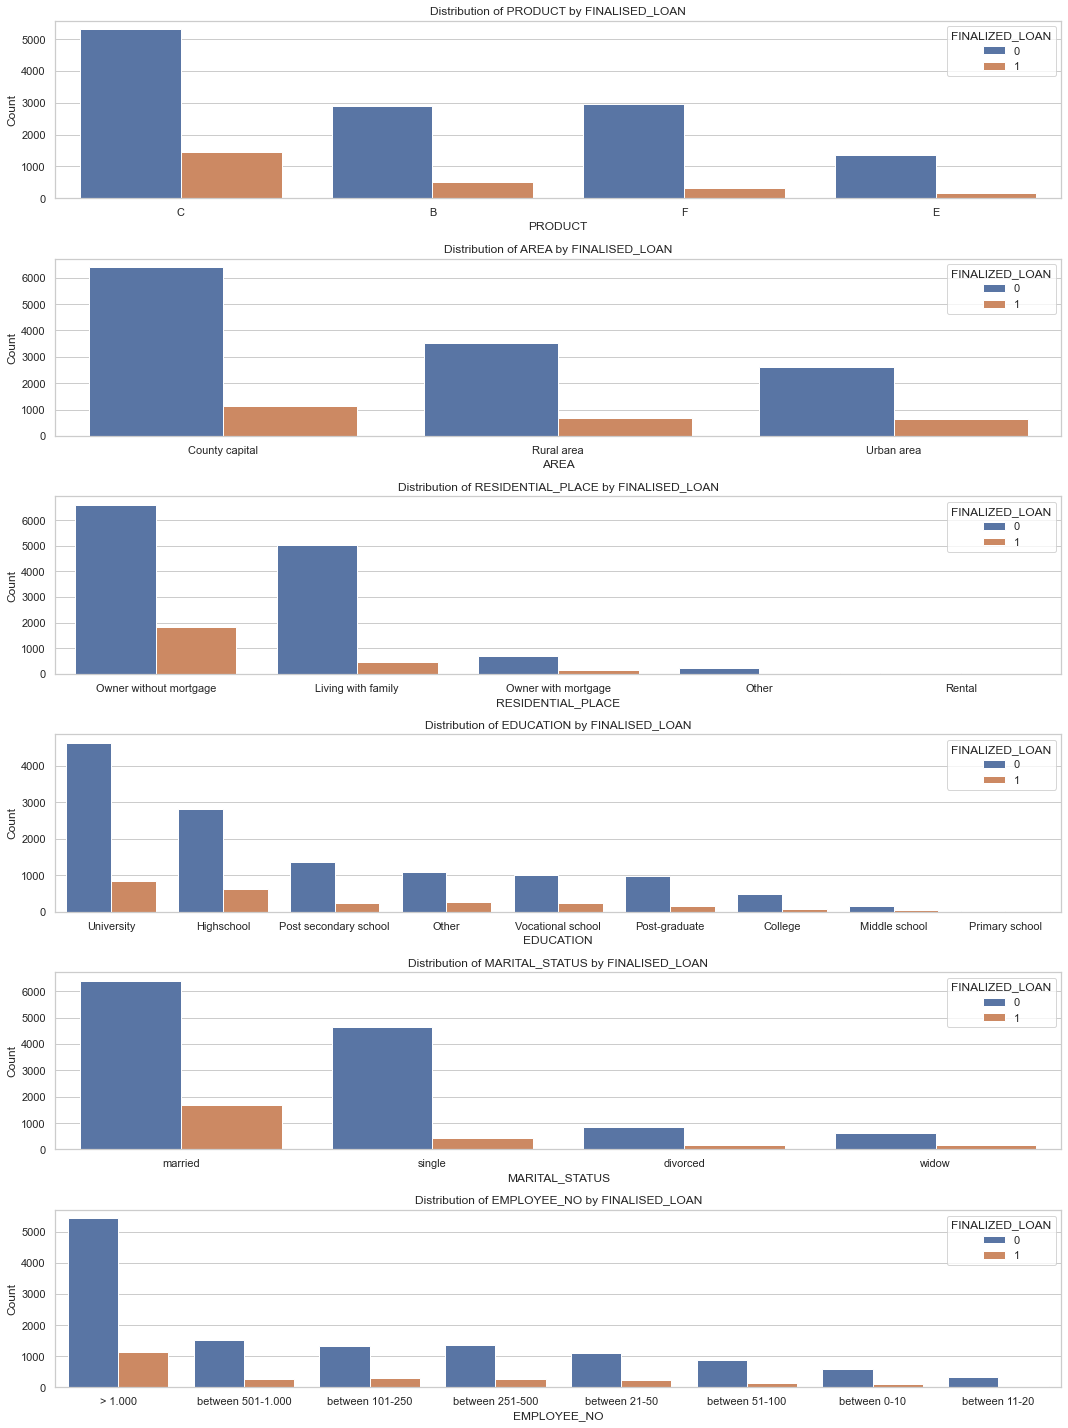

In [49]:
# Plotting bar plots for the selected categorical features against the FINALISED_LOAN

categorical_columns = ['PRODUCT', 'AREA', 'RESIDENTIAL_PLACE', 'EDUCATION', 'MARITAL_STATUS', 'EMPLOYEE_NO']
plt.figure(figsize=(15, 20))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(6, 1, i)
    order = data[column].value_counts().index
    sns.countplot(x=column, hue='FINALIZED_LOAN', data=data, order = order)
    plt.title(f'Distribution of {column} by FINALISED_LOAN')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='FINALIZED_LOAN', loc='upper right')

plt.tight_layout()
plt.show()

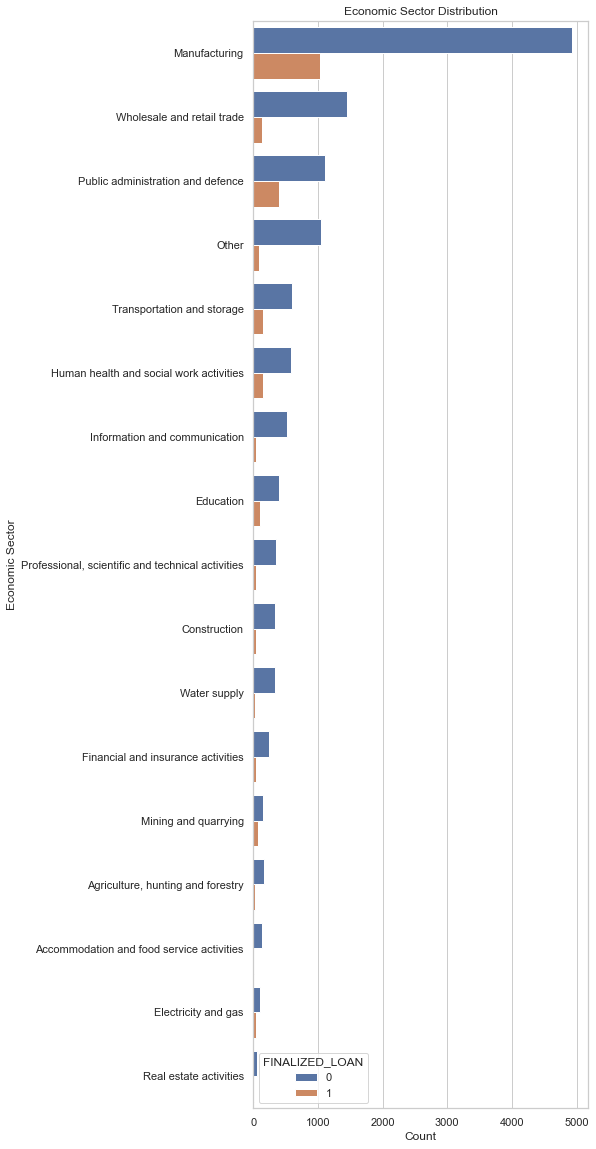

In [50]:
# I have changed the orientation of the plot so that the values on the axis can be readable
plt.figure(figsize=(6, 20)) 
order = data['ECONOMIC_SECTOR'].value_counts().index
sns.countplot(y='ECONOMIC_SECTOR', data=data, order = order, hue = 'FINALIZED_LOAN') 
plt.title('Economic Sector Distribution')
plt.xlabel('Count')
plt.ylabel('Economic Sector') 
plt.show()

In [51]:
# order_by_median = data_no_missing_area.groupby('EDUCATION')['INCOME'].median().reset_index().sort_values('INCOME')['EDUCATION']
# plt.figure(figsize=(24, 16))
# sns.boxplot(y="EDUCATION", x="INCOME", data=data_no_missing_area, width=0.7, order=order_by_median,showfliers=False)

# plt.title('Income distribution in terms of education after inputation', fontsize=16)
# plt.xlabel('Income', fontsize=14)
# plt.ylabel('Education ', fontsize=14)
# plt.show()
# data_no_missing_area["BUSINESS AGE"].max()

In [52]:
# #Let's see the distribution of education in the groups:
# education_data_before=data_no_missing_area.groupby("EDUCATION").size().reset_index(name="count_before")
# education_data_before

In [53]:
# data_without_missing_education=data_no_missing_area[data_no_missing_area['EDUCATION']!="Missing"]
# missing_education_median_incomes=data_without_missing_education.groupby("EDUCATION").median()["INCOME"].reset_index()

# def impute_education(row):
#     if row['EDUCATION'] == "Missing":
#         min_income = float('inf')
#         closest_education = "Missing"
#         for i in range(len(missing_education_median_incomes)):
#             temp = abs(missing_education_median_incomes.at[i, "INCOME"] - row["INCOME"])
#             if temp < min_income:
#                 closest_education = missing_education_median_incomes.at[i, "EDUCATION"]
#                 min_income = temp
#         return closest_education
#     else:
#         return row['EDUCATION']
# data_no_missing_area_copy=data_no_missing_area.copy()

# data_no_missing_area_copy.loc[:,'EDUCATION']=data_no_missing_area.apply(impute_education, axis=1)

# # Lets see how the distribution looks like now, and how the proportion of education changed

In [54]:
# new_row = {'EDUCATION': 'Missing', 'count_after': 0}

# education_data_after=data_no_missing_area_copy.groupby("EDUCATION").size().reset_index(name="count_after")
# education_data_after=pd.concat([education_data_after.iloc[:3], pd.DataFrame([new_row]), education_data_after.iloc[3:]]).reset_index(drop=True)

# education_data_before.merge(education_data_after,on="EDUCATION", suffixes=('_before', '_after')).assign(increase=lambda x: 100*(x['count_after']-x['count_before'])/ x['count_before'])

In [55]:
# # Let's delete showfliers
# plt.figure(figsize=(24, 16))
# sns.boxplot(y="EDUCATION", x="INCOME", data=data_no_missing_area_copy, width=0.7, order=order_by_median,showfliers=False)

# plt.title('Income distribution in terms of education after inputation', fontsize=16)
# plt.xlabel('Income', fontsize=14)
# plt.ylabel('Education ', fontsize=14)
# plt.show()
# data_no_missing_area["BUSINESS AGE"].max()

In [56]:
# # Applying log transformation
# data_no_outlier_relationship['LENGTH_RELATIONSHIP_WITH_CLIENT_LOG'] = np.log1p(data_no_outlier_relationship['LENGTH_RELATIONSHIP_WITH_CLIENT'])

# # Plotting the distribution of the transformed LENGTH_RELATIONSHIP_WITH_CLIENT
# plt.figure(figsize=(10, 6))
# sns.histplot(data_no_outlier_relationship['LENGTH_RELATIONSHIP_WITH_CLIENT_LOG'], kde=True, bins=30)
# plt.title('Rozkład długości relacji z klientem po transformacji logarytmicznej')
# plt.xlabel('Logarytm długości relacji z klientem (lata)')
# plt.ylabel('Liczba klientów')
# plt.show()

# # Calculate the skewness after log transformation
# length_relationship_log_skew = data_no_outlier_relationship['LENGTH_RELATIONSHIP_WITH_CLIENT_LOG'].skew()
# length_relationship_log_skew